In [2]:
# 1 - Importando as bibliotecas necessárias:

import random
import numpy as np
import pandas as pd
import yfinance as yf
#As bibliotecas random, numpy, pandas e yfinance são importadas para realizar diferentes operações no código.

# 2 - Buscar dados históricos da ação PETR4 do Yahoo Finance
ticker = "PETR4.SA"  # Símbolo do ativo PETR4 na bolsa brasileira
start_date = "2022-01-01"
end_date = "2023-06-30"
data = yf.download(ticker, start=start_date, end=end_date)
dados_historicos = data['Close'].values
#Os dados históricos são baixados usando a função yf.download() e armazenados na variável data.
#Os preços de fechamento das ações são extraídos dos dados e armazenados na variável dados_historicos como um array NumPy.

# 3 - Definindo os parâmetros do algoritmo genético
population_size = 100 #define o número de indivíduos na população
generations = 50 #define o número de gerações que o algoritmo irá percorrer
crossover_probability = 0.8 #define a probabilidade de ocorrer o crossover entre os indivíduos durante a reprodução.
mutation_probability = 0.2 #define a probabilidade de ocorrer a mutação em um gene durante a evolução da população.

# 4 - Definir a função de avaliação (fitness)
def evaluate(individual):
    buy_days = [i for i, bit in enumerate(individual) if bit == 1]
    if len(buy_days) < 2:  # Pelo menos duas transações são necessárias para obter lucro
        return 0

    total_profit = 0
    for i in range(len(buy_days)-1):
        buy_day = buy_days[i]
        sell_day = buy_days[i+1]
        buy_price = dados_historicos[buy_day]
        sell_price = dados_historicos[sell_day]
        if sell_price > buy_price:  # Realiza a transação somente se houver lucro
            total_profit += (sell_price - buy_price)
    return total_profit
#A função evaluate() recebe um indivíduo (representado por um cromossomo) como entrada.
#A função identifica os dias de compra e venda do indivíduo com base nos genes de valor 1.
#Se houver menos de duas transações (compra e venda) no cromossomo, não será possível obter lucro, então a função retorna 0.
#Para cada par de dias de compra e venda, o lucro é calculado somente se a venda ocorrer a um preço maior do que a compra.



# 5 - Criar a população inicial
population = []
for _ in range(population_size):
    individual = [random.randint(0, 1) for _ in range(len(dados_historicos))]
    population.append(individual)

    
# A população inicial é criada como uma lista de indivíduos.
#Cada indivíduo é representado por um cromossomo, que é uma sequência de bits (0 ou 1).
#Os cromossomos são gerados aleatoriamente usando a função random.randint().    



# 6 - Executando o algoritmo genético
for _ in range(generations):
    # Avaliar a população
    fitness_values = [evaluate(individual) for individual in population]

    # Adicionar uma pequena quantidade a todos os valores de aptidão
    fitness_values = np.array(fitness_values) + 1e-6

    # Seleção
    selected_indices = random.choices(range(population_size), weights=fitness_values, k=population_size)

    # Crossover
    offspring = []
    for i in range(0, population_size, 2):
        parent1 = population[selected_indices[i]]
        parent2 = population[selected_indices[i+1]]
        if random.random() < crossover_probability:
            crossover_point = random.randint(1, len(parent1)-1)
            child1 = parent1[:crossover_point] + parent2[crossover_point:]
            child2 = parent2[:crossover_point] + parent1[crossover_point:]
            offspring.extend([child1, child2])
        else:
            offspring.extend([parent1, parent2])

    # Mutação
    for i in range(population_size):
        for j in range(len(population[i])):
            if random.random() < mutation_probability:
                population[i][j] = 1 - population[i][j]

    # Atualizar a população com a nova geração
    population = offspring
#O loop for percorre o número de gerações especificado.
#Em cada geração, a população é avaliada, selecionada, realizada a reprodução (crossover) e aplicada a mutação.


# 7 - Avaliar a população final
fitness_values = [evaluate(individual) for individual in population]

# Encontrar o melhor indivíduo
best_individual = population[np.argmax(fitness_values)]

#A população final é avaliada usando a função de avaliação.
#O melhor indivíduo é selecionado com base na sua aptidão máxima.


# 8 - Determinar os dias de compra com base no melhor indivíduo
buy_days = [i for i, bit in enumerate(best_individual) if bit == 1]
#Os dias de compra são determinados a partir do melhor indivíduo encontrado.
#Os índices dos genes com valor 1 são usados para encontrar os dias de compra.


# 9 - Encontrar os melhores dias de compra e venda de cada mês
best_days_per_month = {}
for i in range(len(buy_days)-1):
    buy_day = buy_days[i]
    sell_day = buy_days[i+1]
    buy_price = dados_historicos[buy_day]
    sell_price = dados_historicos[sell_day]
    if sell_price > buy_price:
        date_buy = data.index[buy_day]
        date_sell = data.index[sell_day]
        year = date_buy.year
        month = date_buy.month
        if year not in best_days_per_month:
            best_days_per_month[year] = {}
        if month not in best_days_per_month[year]:
            best_days_per_month[year][month] = []
        best_days_per_month[year][month].append((date_buy, date_sell, buy_price, sell_price))

#Os dias de compra e venda são verificados para cada par consecutivo de dias de compra.
#Se a venda resultar em lucro (o preço de venda for maior que o preço de compra), o par de datas é adicionado ao dicionário best_days_per_month, agrupado por ano e mês.


# Imprimir os resultados
for year, months in best_days_per_month.items():
    for month, dates in months.items():
        print(f"Melhores dias para operações de compra e venda para o mês {month}/{year}:")
        for date_buy, date_sell, buy_price, sell_price in dates:
            print(f"Compra - Data: {date_buy.date()} / Preço: {buy_price:.2f} / Venda - Data: {date_sell.date()} / Preço: {sell_price:.2f}")
        print()

[*********************100%***********************]  1 of 1 completed
Melhores dias para operações de compra e venda para o mês 1/2022:
Compra - Data: 2022-01-03 / Preço: 29.09 / Venda - Data: 2022-01-04 / Preço: 29.20
Compra - Data: 2022-01-05 / Preço: 28.07 / Venda - Data: 2022-01-07 / Preço: 28.18
Compra - Data: 2022-01-07 / Preço: 28.18 / Venda - Data: 2022-01-11 / Preço: 28.84
Compra - Data: 2022-01-11 / Preço: 28.84 / Venda - Data: 2022-01-12 / Preço: 29.72
Compra - Data: 2022-01-12 / Preço: 29.72 / Venda - Data: 2022-01-13 / Preço: 30.32
Compra - Data: 2022-01-13 / Preço: 30.32 / Venda - Data: 2022-01-17 / Preço: 31.50
Compra - Data: 2022-01-19 / Preço: 31.49 / Venda - Data: 2022-01-24 / Preço: 31.95
Compra - Data: 2022-01-24 / Preço: 31.95 / Venda - Data: 2022-01-26 / Preço: 33.87

Melhores dias para operações de compra e venda para o mês 2/2022:
Compra - Data: 2022-02-02 / Preço: 32.52 / Venda - Data: 2022-02-11 / Preço: 33.76
Compra - Data: 2022-02-16 / Preço: 32.93 / Venda - 

[*********************100%***********************]  1 of 1 completed
Melhores dias para operações de compra e venda para o mês 1/2022:
Compra - Data: 2022-01-06 / Preço Mínimo: 27.84 / Venda - Data: 2022-01-10 / Preço Máximo: 28.24
Compra - Data: 2022-01-10 / Preço Mínimo: 27.72 / Venda - Data: 2022-01-11 / Preço Máximo: 29.07
Compra - Data: 2022-01-11 / Preço Mínimo: 27.85 / Venda - Data: 2022-01-12 / Preço Máximo: 29.91
Compra - Data: 2022-01-12 / Preço Mínimo: 28.95 / Venda - Data: 2022-01-13 / Preço Máximo: 30.63
Compra - Data: 2022-01-13 / Preço Mínimo: 29.50 / Venda - Data: 2022-01-14 / Preço Máximo: 31.60
Compra - Data: 2022-01-14 / Preço Mínimo: 30.24 / Venda - Data: 2022-01-20 / Preço Máximo: 32.00
Compra - Data: 2022-01-20 / Preço Mínimo: 31.11 / Venda - Data: 2022-01-21 / Preço Máximo: 31.88
Compra - Data: 2022-01-21 / Preço Mínimo: 31.53 / Venda - Data: 2022-01-27 / Preço Máximo: 34.64
Compra - Data: 2022-01-27 / Preço Mínimo: 33.17 / Venda - Data: 2022-01-28 / Preço Máximo

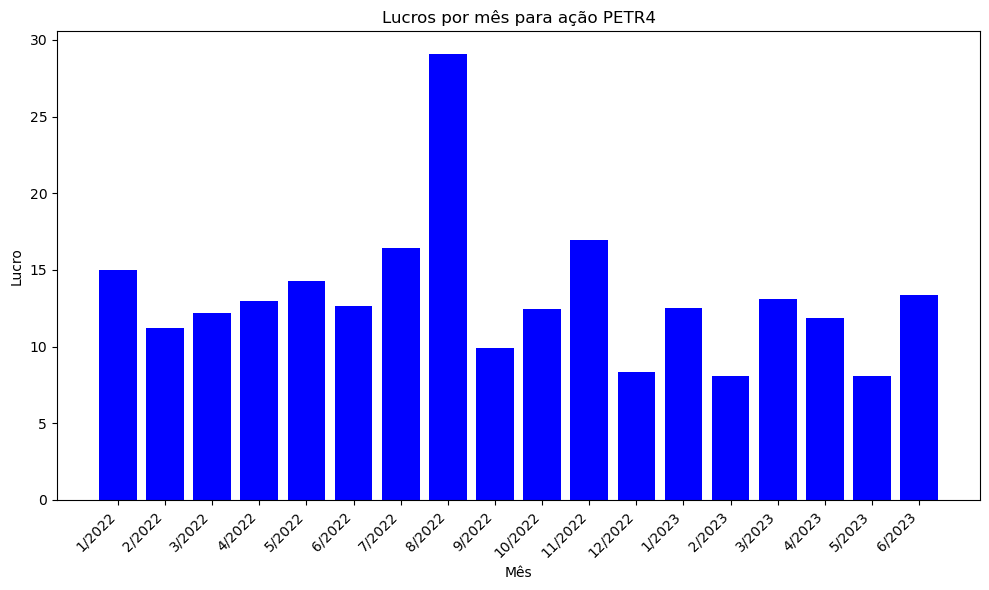

In [10]:
# 1 - Importando as bibliotecas necessárias:
import random
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
#As bibliotecas random, numpy, pandas e yfinance são importadas para realizar diferentes operações no código.


# 2 - Buscar dados históricos da ação PETR4 do Yahoo Finance
ticker = "PETR4.SA"  # Símbolo do ativo PETR4 na bolsa brasileira
start_date = "2022-01-01"
end_date = "2023-06-30"
data = yf.download(ticker, start=start_date, end=end_date)
dados_historicos_min = data['Low'].values
dados_historicos_max = data['High'].values
#Os dados históricos são baixados usando a função yf.download() e armazenados na variável data.
#Os preços máximos e mínimos da ações são extraídos dos dados e armazenados na variável dados_historicos_min e max como um array NumPy.


# 3 - Definindo os parâmetros do algoritmo genético
population_size = 100 #define o número de indivíduos na população
generations = 50 #define o número de gerações que o algoritmo irá percorrer
crossover_probability = 0.8 #define a probabilidade de ocorrer o crossover entre os indivíduos durante a reprodução.
mutation_probability = 0.2 #define a probabilidade de ocorrer a mutação em um gene durante a evolução da população.

# 4 - Definir a função de avaliação (fitness)
def evaluate(individual):
    buy_days = [i for i, bit in enumerate(individual) if bit == 1]
    if len(buy_days) < 2:  # Pelo menos duas transações são necessárias para obter lucro
        return 0

    total_profit = 0
    for i in range(len(buy_days)-1):
        buy_day = buy_days[i]
        sell_day = buy_days[i+1]
        buy_price = dados_historicos_min[buy_day]
        sell_price = dados_historicos_max[sell_day]
        if sell_price > buy_price:  # Realiza a transação somente se houver lucro
            total_profit += (sell_price - buy_price)
    return total_profit
#A função evaluate() recebe um indivíduo (representado por um cromossomo) como entrada.
#A função identifica os dias de compra e venda do indivíduo com base nos genes de valor 1.
#Se houver menos de duas transações (compra e venda) no cromossomo, não será possível obter lucro, então a função retorna 0.
#Para cada par de dias de compra e venda, o lucro é calculado somente se a venda ocorrer a um preço maior do que a compra.



# 5 - Criar a população inicial
population = []
for _ in range(population_size):
    individual = [random.randint(0, 1) for _ in range(len(dados_historicos_min))]
    population.append(individual)
# A população inicial é criada como uma lista de indivíduos.
#Cada indivíduo é representado por um cromossomo, que é uma sequência de bits (0 ou 1).
#Os cromossomos são gerados aleatoriamente usando a função random.randint().    

# 6 - Executar o algoritmo genético
for _ in range(generations):
    # Avaliar a população
    fitness_values = [evaluate(individual) for individual in population]

    # Adicionar uma pequena quantidade a todos os valores de aptidão
    fitness_values = np.array(fitness_values) + 1e-6

    # Seleção
    selected_indices = random.choices(range(population_size), weights=fitness_values, k=population_size)

    # Crossover
    offspring = []
    for i in range(0, population_size, 2):
        parent1 = population[selected_indices[i]]
        parent2 = population[selected_indices[i+1]]
        if random.random() < crossover_probability:
            crossover_point = random.randint(1, len(parent1)-1)
            child1 = parent1[:crossover_point] + parent2[crossover_point:]
            child2 = parent2[:crossover_point] + parent1[crossover_point:]
            offspring.extend([child1, child2])
        else:
            offspring.extend([parent1, parent2])

    # Mutação
    for i in range(population_size):
        for j in range(len(population[i])):
            if random.random() < mutation_probability:
                population[i][j] = 1 - population[i][j]

    # Atualizar a população com a nova geração
    population = offspring

#O loop for percorre o número de gerações especificado.
#Em cada geração, a população é avaliada, selecionada, realizada a reprodução (crossover) e aplicada a mutação.


# 7 - Avaliar a população final
fitness_values = [evaluate(individual) for individual in population]
# Encontrar o melhor indivíduo
best_individual = population[np.argmax(fitness_values)]

#A população final é avaliada usando a função de avaliação.
#O melhor indivíduo é selecionado com base na sua aptidão máxima.

# 8 - Determinar os dias de compra com base no melhor indivíduo encontrado
buy_days = [i for i, bit in enumerate(best_individual) if bit == 1]
#Os dias de compra são determinados a partir do melhor indivíduo encontrado.
#Os índices dos genes com valor 1 são usados para encontrar os dias de compra.


# 9 - Encontrar os melhores dias de compra e venda de cada mês, levando em consideração as máximas e as mínimas
best_days_per_month = {}
for i in range(len(buy_days)-1):
    buy_day = buy_days[i]
    sell_day = buy_days[i+1]
    buy_price = dados_historicos_min[buy_day]
    sell_price = dados_historicos_max[sell_day]
    if sell_price > buy_price:
        date_buy = data.index[buy_day]
        date_sell = data.index[sell_day]
        year = date_buy.year
        month = date_buy.month
        if year not in best_days_per_month:
            best_days_per_month[year] = {}
        if month not in best_days_per_month[year]:
            best_days_per_month[year][month] = []
        best_days_per_month[year][month].append((date_buy, date_sell, buy_price, sell_price))

#Os dias de compra e venda são verificados para cada par consecutivo de dias de compra.
#Se a venda resultar em lucro (o preço de venda for maior que o preço de compra), o par de datas é adicionado ao dicionário best_days_per_month, agrupado por ano e mês.
        

# 10 - Imprimir os resultados
for year, months in best_days_per_month.items():
    for month, dates in months.items():
        print(f"Melhores dias para operações de compra e venda para o mês {month}/{year}:")
        for date_buy, date_sell, buy_price, sell_price in dates:
            print(f"Compra - Data: {date_buy.date()} / Preço Mínimo: {buy_price:.2f} / Venda - Data: {date_sell.date()} / Preço Máximo: {sell_price:.2f}")
        print()
        
# 11 - Encontrar os lucros ótimo para cada um dos meses analisados
profits_per_month = {}
for i in range(len(buy_days)-1):
    buy_day = buy_days[i]
    sell_day = buy_days[i+1]
    buy_price = dados_historicos_min[buy_day]
    sell_price = dados_historicos_max[sell_day]
    if sell_price > buy_price:
        date_buy = data.index[buy_day]
        year = date_buy.year
        month = date_buy.month
        profit = sell_price - buy_price
        if year not in profits_per_month:
            profits_per_month[year] = {}
        if month not in profits_per_month[year]:
            profits_per_month[year][month] = []
        profits_per_month[year][month].append(profit)

# 12 - Imprimir os lucros por mês
for year, months in profits_per_month.items():
    for month, profits in months.items():
        total_profit = sum(profits)
        print(f"Lucro para o mês {month}/{year}: {total_profit:.2f}")
        
# 13 - Gerar o gráfico de lucros por mês
months_labels = [f"{month}/{year}" for year, months in profits_per_month.items() for month in months]
profits = [sum(profits) for months in profits_per_month.values() for profits in months.values()]

plt.figure(figsize=(10, 6))
plt.bar(months_labels, profits, color='blue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Mês')
plt.ylabel('Lucro')
plt.title('Lucros por mês para ação PETR4')
plt.tight_layout()
plt.show()